# Tutorial for the pushrimkinetics extension

The pushrimkinetics extension to Kinetics Toolkit allows reading and processing kinetics recorded by instrumented wheelchair wheels such as SmartWheel. Here is a short demonstration of this extension.

In [1]:
%matplotlib inline

In [2]:
# Import usual modules
import kineticstoolkit.lab as ktk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import this module (you should copy kineticstoolkit_pushrimkinetics.py in the current directory)
import kineticstoolkit_pushrimkinetics as pk

## Reading data from file

The SmartWheel generates files either in a `csv` format (if using the SmartWheel software) or `txt` format (if using the MMD cards). Both file formats can be read by the function `read_smartwheel`:

In [3]:
kinetics = pk.read_smartwheel("tutorial_data/pushrimkinetics_offsets_propulsion.csv")

Let see what we loaded:

In [4]:
kinetics.data

{
       'Index': array([ 1., 2., 3., ..., 7680., 7681., 7682.])
    'Channels': <array of shape (7682, 6)>
      'Forces': <array of shape (7682, 4)>
     'Moments': <array of shape (7682, 4)>
       'Angle': <array of shape (7682,)>
}

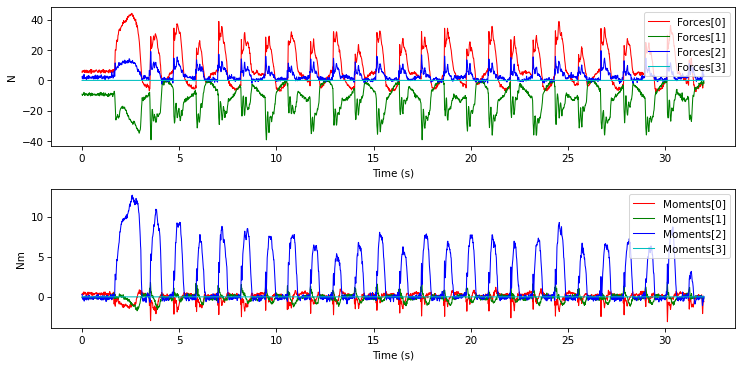

In [5]:
plt.subplot(2, 1, 1)
kinetics.plot("Forces")
plt.subplot(2, 1, 2)
kinetics.plot("Moments")
plt.tight_layout()

## Apply calibration

If the loaded data doesn't include forces and moments but only raw data (for exemple, when loading data from a SmartWheel's SD card), we must calculate the forces and moments based on a calibration matrix. The function `apply_calibration()` performs this calculation. Here is its docstring:

In [6]:
?pk.apply_calibration

Signature:
pk.apply_calibration(
    ts: kineticstoolkit.timeseries.TimeSeries,
    gains: numpy.ndarray,
    offsets: numpy.ndarray = array([0., 0., 0., 0., 0., 0.]),
    *,
    transducer: str = 'force_cell',
    reference_frame: str = 'wheel',
) -> kineticstoolkit.timeseries.TimeSeries
Docstring:
Calculate pushrim forces and moments based on raw channel values.

For standard force cells (with each channel being a raw value
corresponding to Fx, Fy, Fz, Mx, My, Mz, respectively), calculates
the forces and moments using a sensitivity matrix (gains) and an
offset vector (offsets).

For SmartWheel, calculates the forces and moments using a gain
vector (gains) and an offset vector (offsets).

    [Fx, Fy, Fz, Mx, My, Mz] = gains @ channels + offsets

Parameters
----------
ts
    Input TimeSeries that must contain a 'Channels' key in its data dict.
gains
    6x6 gain matrix (force_cell) or gain vector of length 6 (smartwheel).
offsets
    Optional. Offset vector of length 6.
transducer
   

Let's apply a calibration on raw channels:

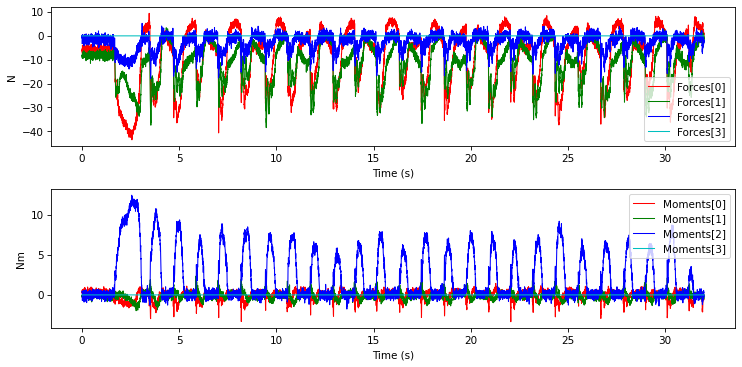

In [7]:
# This instrumented wheel's calibration:

# Gains for the 3 forces and 3 moments, in N/channel value and Nm/channel value.
gains = [-0.106, 0.106, 0.094, 0.022, -0.022, 0.0234999]

# Offsets for the 3 forces and 3 moments
offsets = [0.0, 10.0, 0.0, 0.0, 0.0, 0.0]

# Perform the calculation
new_kinetics = pk.apply_calibration(
    kinetics,
    gains=gains,
    offsets=offsets,
    transducer="smartwheel",
    reference_frame="hub",
)

# Plot the results
plt.subplot(2, 1, 1)
new_kinetics.plot("Forces")
plt.subplot(2, 1, 2)
new_kinetics.plot("Moments")
plt.tight_layout()

We observe some sign differences here. In fact, the SmartWheel softwares inverts some signals based on the SmartWheel's sign convention and the side of the wheel. When the forces and moments are reconstructed from raw data, these sign changes do not happen, which explains these discrepancies.

## Removing dynamic offsets in forces and moments

We observe in the last graphs that dynamic (sinusoidal) offsets are presents mostly in the forces but also in the moments. We can auto-remove these offsets using `remove_offsets()`:

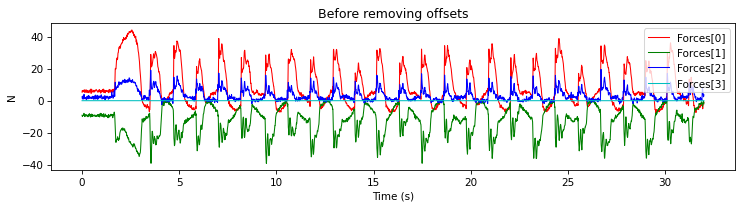

In [8]:
plt.subplot(2, 1, 1)
kinetics.plot("Forces")
plt.title("Before removing offsets")
plt.tight_layout()

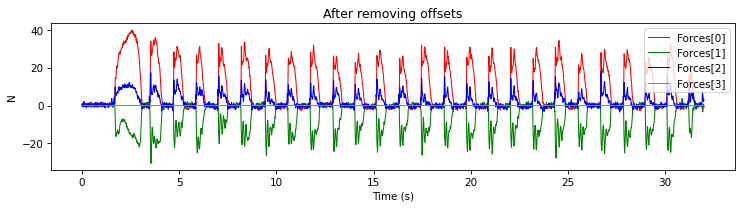

In [9]:
kinetics = pk.remove_offsets(kinetics)

plt.subplot(2, 1, 2)
kinetics.plot("Forces")
plt.title("After removing offsets")
plt.tight_layout()

This automatic method has only be validated for straight-line, level-ground propulsion. For any other condition, a baseline trial is required. A baseline trial is a trial where an operator pushes the wheelchair but no external force appart from gravity is applied on the instrumented wheel. Please consult the function's docstring to learn more on using a baseline trial.

## Calculate velocity and power

Thee wheel velocity is calculated from the wheel angle with a derivative Savitsky-Golay filter, using `calculate_velocity()`. Once the velocity has been calculated, the output power can also be calculated by multiplying the velocity by the propulsion moment, using `calculate_power()`:

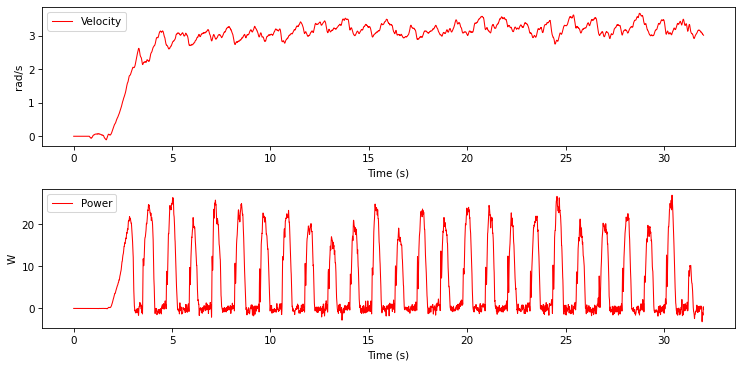

In [10]:
kinetics = pk.calculate_velocity(kinetics)

kinetics = pk.calculate_power(kinetics)

plt.subplot(2, 1, 1)
kinetics.plot("Velocity")
plt.subplot(2, 1, 2)
kinetics.plot("Power")
plt.tight_layout()

## Detecting the pushes

The rest of this tutorial only uses features from Kinetics Toolkit or Pandas, to complete a typical analysis of wheelchair kinetics.

To detect the pushes, we will use KTK's `cycles` module that provides tools to detect and manage cycles. Here we use `ktk.cycles.detect_cycles()` to detect the pushes using these specifications:

- a push starts when the total force crosses 5 N upward;
- a push ends when the total force crosses 2 N downward;
- for a push to be valid, it must last at least 100 ms;
- to be valid, the total force must reach 25 N.

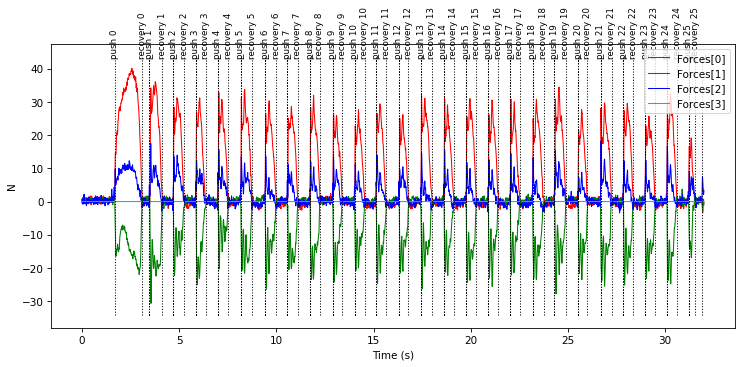

In [11]:
# Create the total force data
kinetics.data["Ftot"] = np.sqrt(np.sum(kinetics.data["Forces"] ** 2, axis=1))

kinetics = ktk.cycles.detect_cycles(
    kinetics,
    "Ftot",
    event_names=["push", "recovery"],
    thresholds=[5.0, 2.0],
    min_durations=[0.1, 0.1],
    min_peak_heights=[25.0, -np.Inf],
)

kinetics.plot("Forces")
plt.tight_layout()

## Extracting spatiotemporal and kinetic parameters

As a conclusion to this tutorial, we will now extract some key spatiotemporal and kinetic parameters from these data, and express those parameters as a pandas DataFrame. Obviously, this is only an example and many other parameters can be calculated using a similar procedure.

In [12]:
n_cycles = 15  # Number of cycles to analyze

records = []  # Init a list that will contains the results of the analysis

for i_cycle in range(n_cycles):

    # Get a TimeSeries that spans only the push i_push
    ts_push = kinetics.get_ts_between_events("push", "recovery", i_cycle, i_cycle)

    # Get a TimeSeries that spans the entire cycle i_push
    ts_cycle = kinetics.get_ts_between_events("push", "_", i_cycle, i_cycle)

    # Get some spatiotemporal parameters
    push_time = ts_push.time[-1] - ts_push.time[0]
    cycle_time = ts_cycle.time[-1] - ts_cycle.time[0]
    recovery_time = cycle_time - push_time

    push_angle = ts_push.data["Angle"][-1] - ts_push.data["Angle"][0]

    # Get some kinetic parameters
    propulsion_moment_mean = np.mean(ts_push.data["Moments"][:, 2])
    propulsion_moment_max = np.max(ts_push.data["Moments"][:, 2])

    total_force_mean = np.mean(ts_push.data["Ftot"])
    total_force_max = np.max(ts_push.data["Ftot"])

    # Record this information in the records list
    records.append(
        {
            "Push time (s)": push_time,
            "Recovery time (s)": recovery_time,
            "Cycle time (s)": cycle_time,
            "Push angle (deg)": np.rad2deg(push_angle),
            "Mean propulsion moment (Nm)": propulsion_moment_mean,
            "Max propulsion moment (Nm)": propulsion_moment_max,
            "Mean total force (N)": total_force_mean,
            "Max total force (N)": total_force_max,
        }
    )

# Create and show a DataFrame of this information
df = pd.DataFrame.from_dict(records)

# Copy the dataframe to the clipboard for pasting into Excel (facultative)
df.to_clipboard()

# Print the dataframe here
df

,Push time (s),Recovery time (s),Cycle time (s),Push angle (deg),Mean propulsion moment (Nm),Max propulsion moment (Nm),Mean total force (N),Max total force (N)
0,1.404167,0.358333,1.762500,75.85,9.106452,12.716142,34.117531,44.257457
1,0.654167,0.579167,1.233333,88.33,6.992656,11.005038,30.669055,47.699743
2,0.554167,0.583333,1.137500,88.51,6.244814,9.327931,25.279054,37.581425
3,0.495833,0.633333,1.129167,79.80,4.328190,7.851847,23.573272,39.199059
4,0.533333,0.629167,1.162500,90.70,5.271423,8.831854,22.133097,40.147530
5,0.587500,0.675000,1.262500,97.12,5.611598,8.544609,25.567489,41.677356
6,0.550000,0.570833,1.120833,93.60,4.906104,7.642254,23.327076,37.582148
7,0.537500,0.637500,1.175000,90.00,5.233192,7.801526,23.085664,36.135763
8,0.487500,0.654167,1.141667,86.13,4.663521,6.557192,25.296090,40.663234
9,0.479167,0.658333,1.137500,87.18,3.506395,5.401392,21.393315,35.221362
